Here, we attempt to fit $$\rho_\eta(\log\eta)=f\bigg[\rho_\Phi(\log\Phi),\;\rho_{Bi}(\log Bi)\bigg]\,,$$ where $\rho_\eta$, $\rho_\Phi$, and $\rho_{Bi}$ are $\texttt{sklearn.preprocessing.MinMaxScaler}$ objects.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch

import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from tqdm.notebook import tqdm, trange

In [2]:
load_weights = True

In [3]:
plt.rc("axes",
    axisbelow = True,
    labelsize = 15,
    titlesize = 18
)
plt.rc("font", family = "serif")
plt.rc("image", cmap = "viridis")
plt.rc("legend",
    edgecolor = "k",
    fontsize = 12,
    framealpha = 1.0
)
plt.rc("text", usetex = True)
plt.rc("xtick", labelsize = 12)
plt.rc("ytick", labelsize = 12)

np.set_printoptions(
    precision = 5,
    linewidth = 99,
)

np.random.seed(6)
generator = np.random.default_rng(6)
torch.set_default_dtype(torch.float64)

def tensor2array(t):
    return t.detach().cpu().numpy()

def vector_cosine(u, v):
    norm_u = torch.linalg.vector_norm(u, dim = 1)
    norm_v = torch.linalg.vector_norm(v, dim = 1)
    
    dot_product = torch.mul(u, v).sum(dim = 1)
    
    return dot_product/(norm_u*norm_v)

start_time = datetime.now()

# **Generate Data**

In [4]:
def effectiveness_factor(phi, biot):
    group = 1.0/np.tanh(3.0*phi) - 1.0/(3.0*phi)
    return group/(1.0 + phi*group/biot)/phi

In [5]:
lo_phi = -2.0
hi_phi = 6.0
lo_biot = -4.0
hi_biot = 8.0

phi = 10.0**generator.uniform(low = lo_phi, high = hi_phi, size = 10000)
biot = 10.0**generator.uniform(low = lo_biot, high = hi_biot, size = 10000)
eta = effectiveness_factor(phi, biot)

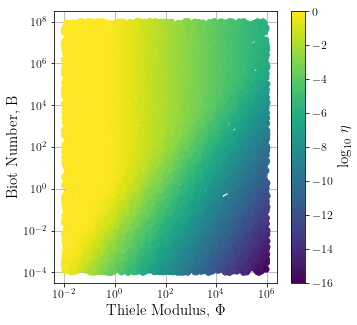

In [6]:
fig1 = plt.figure(figsize = (5, 5))
ax11 = fig1.add_subplot(111)
cs = ax11.scatter(phi, biot, c = np.log10(eta), vmin = -16.0, vmax = 0.0)
cbar = plt.colorbar(cs)
ax11.set_xscale("log")
ax11.set_yscale("log")
ax11.set_xlim((10**-2.4, 10**6.4))
ax11.set_ylim((10**-4.5, 10**8.5))
ax11.set_xticks(np.logspace(-2.0, 6.0, 5))
ax11.set_yticks(np.logspace(-4.0, 8.0, 7))
ax11.set_xlabel(r"Thiele Modulus, $\Phi$", fontsize = 15)
ax11.set_ylabel(r"Biot Number, B", fontsize = 15)
cbar.set_label(r"$\log_{10}\,\eta$", fontsize = 15)
ax11.grid(True)

# **Build and Train Neural Network**

In [7]:
class FeedForward(nn.Module):
    def __init__(self, inp = 2, outp = 2):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(inp, 20) # fully connected layers
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, outp)

    def forward(self, x):
        if x.requires_grad == False:
            x.requires_grad = True  # Keep track of gradient wrt input.

        y = torch.tanh(self.fc1(x))
        y = torch.tanh(self.fc2(y))
        y = torch.tanh(self.fc3(y))
        y = torch.tanh(self.fc4(y))
        y = (self.fc5(y))

        return y

In [8]:
bounds = (1.0, 2.0)

phi_scaler = MinMaxScaler(feature_range = bounds)
scaled_phi = phi_scaler.fit_transform(np.log10(phi).reshape(-1, 1))
def phi_unscaler(tensor_phi):
    return phi_scaler.inverse_transform(tensor2array(tensor_phi).reshape(-1, 1))

biot_scaler = MinMaxScaler(feature_range = bounds)
scaled_biot = biot_scaler.fit_transform(np.log10(biot).reshape(-1, 1))
def biot_unscaler(tensor_biot):
    return biot_scaler.inverse_transform(tensor2array(tensor_biot).reshape(-1, 1))

eta_scaler = MinMaxScaler(feature_range = bounds)
scaled_eta = eta_scaler.fit_transform(np.log10(eta).reshape(-1, 1))
def eta_unscaler(tensor_eta):
    return eta_scaler.inverse_transform(tensor2array(tensor_eta).reshape(-1, 1))

In [9]:
criterion = nn.MSELoss(reduction = "mean")

input_data = autograd.Variable(
    torch.from_numpy(np.c_[
        scaled_phi,
        scaled_biot
    ])
)
input_data.requires_grad = True

output_data = autograd.Variable(
    torch.from_numpy(
        scaled_eta
    )
)
conformality_zeros = torch.zeros(output_data.shape[0])

In [10]:
encoder = FeedForward()
decoder = FeedForward()
predictor = FeedForward(inp = 1, outp = 1)
estimator = None

In [11]:
encoding_optimizer = optim.Adam(encoder.parameters(), lr = 0.001)
encoding_scheduler = optim.lr_scheduler.MultiStepLR(
    encoding_optimizer,
    milestones = [100, 1000, 25000],
    gamma = 0.1
)

decoding_optimizer = optim.Adam(decoder.parameters(), lr = 0.001)
decoding_scheduler = optim.lr_scheduler.MultiStepLR(
    decoding_optimizer,
    milestones = [100, 1000, 25000],
    gamma = 0.1
)

prediction_optimizer = optim.Adam(predictor.parameters(), lr = 0.001)
prediction_scheduler = optim.lr_scheduler.MultiStepLR(
    prediction_optimizer,
    milestones = [100, 1000, 25000],
    gamma = 0.1
)

if estimator is None:
    estimation_optimizer = None
    estimation_scheduler = None
else:
    estimation_optimizer = optim.Adam(estimator.parameters(), lr = 0.001)
    estimation_scheduler = optim.lr_scheduler.MultiStepLR(
        estimation_optimizer,
        milestones = [100, 5000],
        gamma = 0.1
    )

In [12]:
if load_weights:
    try:
        begin_task = datetime.now()
        trained_model = torch.load("Effectiveness_Factor_CAE.pt")
        
        encoder.load_state_dict(trained_model["encoder_state_dict"])
        encoding_optimizer.load_state_dict(trained_model["encoding_optimizer_state_dict"])
        encoder.eval()

        decoder.load_state_dict(trained_model["decoder_state_dict"])
        decoding_optimizer.load_state_dict(trained_model["decoding_optimizer_state_dict"])
        decoder.eval()

        predictor.load_state_dict(trained_model["predictor_state_dict"])
        prediction_optimizer.load_state_dict(trained_model["prediction_optimizer_state_dict"])
        predictor.eval()
        
        print("Load Time:", datetime.now() - begin_task)
    except FileNotFoundError:
        load_weights = False

if not load_weights:
    num_epochs = 50000
    report = 100
    conformality_weight = 33.3
    loss_values_by_epoch = np.zeros((num_epochs, 2))

    for epoch in trange(num_epochs):
        # Conformal Criterion, Gradients:
        center_data = encoder(input_data)
        input_reconstruction = decoder(center_data)

        conformality_gradients = list()
        for i in range(input_data.shape[1]):
            conformality_gradients.append(
                autograd.grad(
                    center_data[:,i],
                    input_data,
                    torch.ones_like(center_data[:,i]),
                    retain_graph = True,
                    allow_unused = True,
                    create_graph = True
                )[0]
            )

        # Conformal Criterion, Loss:
        conformality_loss = criterion(input_reconstruction, input_data)
        for (i, j) in itertools.combinations(range(input_data.shape[1]), 2):
            cosine = vector_cosine(
                conformality_gradients[i],
                conformality_gradients[j]
            )

            conformality_loss += conformality_weight*criterion(
                cosine,
                conformality_zeros
            )

        # Backward Pass and Update:
        encoding_optimizer.zero_grad()
        decoding_optimizer.zero_grad()
        conformality_loss.backward(retain_graph = True)
        encoding_optimizer.step()
        decoding_optimizer.step()

        # Prediction Criterion, Loss:
        center_prediction = encoder(input_data)
        output_prediction = predictor(
            torch.unsqueeze(center_prediction[:,0], dim = 1)
        )
        prediction_loss = criterion(output_prediction, output_data)

        # Backward Pass and Update:
        encoding_optimizer.zero_grad()
        prediction_optimizer.zero_grad()
        prediction_loss.backward(retain_graph = True)
        encoding_optimizer.step()
        prediction_optimizer.step()

        # Update Learning Rates:
        encoding_scheduler.step()
        decoding_scheduler.step()
        prediction_scheduler.step()

        loss_values_by_epoch[epoch] = [
            conformality_loss.item(),
            prediction_loss.item()
        ]
        if report > 0 and ((epoch + 1) % report == 0 or epoch == 0):
            print("Epoch %6d\nConf. Loss: %12.8f\nPred. Loss: %12.8f\n" % (
                epoch + 1,
                conformality_loss.item(),
                prediction_loss.item()
            ))

Load Time: 0:00:00.015998


In [13]:
conformal_coordinates = encoder(input_data)
input_reconstruction = decoder(conformal_coordinates)

# **Plots and Analysis**

In [14]:
if not load_weights:
    fig2 = plt.figure(figsize = (10, 10))
    ax21 = fig2.add_subplot(111)
    ax21.loglog(
        1 + np.arange(num_epochs),
        loss_values_by_epoch[:,0],
        "k.",
        label = "Conformality",
        linewidth = 2.0
    )
    ax21.loglog(
        1 + np.arange(num_epochs),
        loss_values_by_epoch[:,1],
        "r-",
        label = "Prediction",
        linewidth = 2.0
    )
    ax21.set_xlabel("Epoch")
    ax21.set_ylabel("Loss")
    ax21.legend(fontsize = 15, framealpha = 1.0, edgecolor = "k")
    ax21.grid(True)

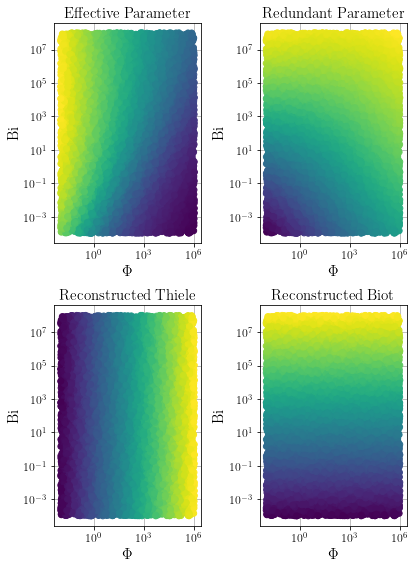

In [15]:
color_vals = tensor2array(
    torch.cat([
        conformal_coordinates,
        input_reconstruction
    ], dim = 1)
)

labels = [
    "Effective Parameter",
    "Redundant Parameter",
    "Reconstructed Thiele",
    "Reconstructed Biot"
]

fig3 = plt.figure(figsize = (6, 8))
for (k, lab) in enumerate(labels):
    ax = fig3.add_subplot(221 + k, aspect = "equal")
    ax.scatter(phi, biot, c = color_vals[:,k])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$\Phi$", fontsize = 15)
    ax.set_ylabel(r"Bi", fontsize = 15)
    ax.set_title(lab, fontsize = 15)
    ax.grid(True)
plt.tight_layout()

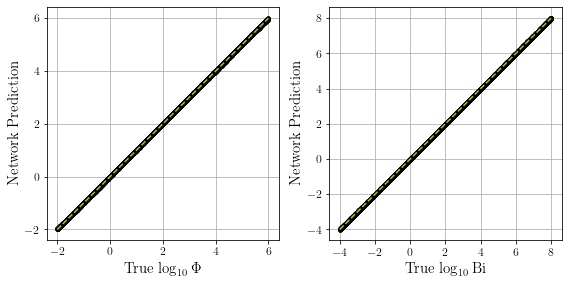

In [16]:
fig3b = plt.figure(figsize = (8, 4))
ax3b1 = fig3b.add_subplot(121, aspect = "equal")
ax3b1.plot(
    phi_unscaler(input_data[:,0]),
    phi_unscaler(input_reconstruction[:,0]),
    "k."
)
ax3b1.plot([lo_phi, hi_phi], [lo_phi, hi_phi], "y--")
ax3b1.set_xticks(np.linspace(lo_phi, hi_phi, 5))
ax3b1.set_yticks(np.linspace(lo_phi, hi_phi, 5))
ax3b1.set_xlabel(r"True $\log_{10}\Phi$", fontsize = 15)
ax3b1.set_ylabel("Network Prediction", fontsize = 15)
ax3b1.grid(True)
ax3b2 = fig3b.add_subplot(122, aspect = "equal")
ax3b2.plot(
    biot_unscaler(input_data[:,1]),
    biot_unscaler(input_reconstruction[:,1]),
    "k."
)
ax3b2.plot([lo_biot, hi_biot], [lo_biot, hi_biot], "y--")
ax3b2.set_xticks(np.linspace(lo_biot, hi_biot, 7))
ax3b2.set_yticks(np.linspace(lo_biot, hi_biot, 7))
ax3b2.set_xlabel(r"True $\log_{10}\,$Bi", fontsize = 15)
ax3b2.set_ylabel("Network Prediction", fontsize = 15)
ax3b2.grid(True)
plt.tight_layout()

In [17]:
ranges = np.c_[
    np.min(color_vals, axis = 0),
    np.max(color_vals, axis = 0)
]

ranges

array([[-1.2296 ,  1.42486],
       [-1.22411,  1.93023],
       [ 1.00151,  2.00116],
       [ 0.99817,  2.0021 ]])

In [18]:
effective_fine_values = np.linspace(*ranges[0], 1000)[1:-1]
redundant_fine_values = np.linspace(*ranges[1], 1000)[1:-1]
effective_wire_values = np.linspace(*ranges[0], 12)[1:-1]
redundant_wire_values = np.linspace(*ranges[1], 12)[1:-1]

(t1, t2) = np.meshgrid(effective_wire_values, redundant_fine_values)
conformal_effective_inputs = torch.from_numpy(
    np.c_[t1.flatten(), t2.flatten()]
)

(t1, t2) = np.meshgrid(effective_fine_values, redundant_wire_values)
conformal_redundant_inputs = torch.from_numpy(
    np.c_[t1.flatten(), t2.flatten()]
)

del t1, t2

conformal_effective_outputs = decoder(conformal_effective_inputs)
conformal_redundant_outputs = decoder(conformal_redundant_inputs)

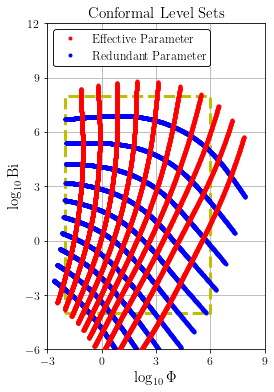

In [19]:
fig4 = plt.figure(figsize = (4, 6))
ax41 = fig4.add_subplot(111, aspect = "equal")
ax41.plot(
    [lo_phi, hi_phi, hi_phi, lo_phi, lo_phi],
    [lo_biot, lo_biot, hi_biot, hi_biot, lo_biot],
    "y--", zorder = 1, linewidth = 3
)
ax41.plot(
    phi_unscaler(conformal_effective_outputs[:,0]),
    biot_unscaler(conformal_effective_outputs[:,1]),
    "r.",
    label = "Effective Parameter",
    zorder = 3
)
ax41.plot(
    phi_unscaler(conformal_redundant_outputs[:,0]),
    biot_unscaler(conformal_redundant_outputs[:,1]),
    "b.",
    label = "Redundant Parameter",
    zorder = 2
)
ax41.set_xlim((-3.0, 9.0))
ax41.set_ylim((-6.0, 12.0))
ax41.set_xticks(np.linspace(*ax41.get_xlim(), 5))
ax41.set_yticks(np.linspace(*ax41.get_ylim(), 7))
ax41.set_xlabel(r"$\log_{10}\Phi$", fontsize = 15)
ax41.set_ylabel(r"$\log_{10}\,$Bi", fontsize = 15)
ax41.set_title("Conformal Level Sets", fontsize = 15)
ax41.legend(
    edgecolor = "k",
    fontsize = 12,
    framealpha = 0.9,
    loc = "upper left"
)
ax41.grid(True)

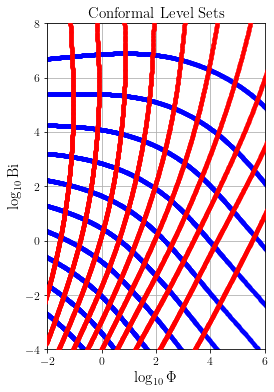

In [20]:
fig4 = plt.figure(figsize = (4, 6))
ax41 = fig4.add_subplot(111, aspect = "equal")
ax41.plot(
    phi_unscaler(conformal_effective_outputs[:,0]),
    biot_unscaler(conformal_effective_outputs[:,1]),
    "r.",
    zorder = 3
)
ax41.plot(
    phi_unscaler(conformal_redundant_outputs[:,0]),
    biot_unscaler(conformal_redundant_outputs[:,1]),
    "b.",
    zorder = 2
)
ax41.set_xlim((lo_phi, hi_phi))
ax41.set_ylim((lo_biot, hi_biot))
ax41.set_xticks(np.linspace(*ax41.get_xlim(), 5))
ax41.set_yticks(np.linspace(*ax41.get_ylim(), 7))
ax41.set_xlabel(r"$\log_{10}\Phi$", fontsize = 15)
ax41.set_ylabel(r"$\log_{10}\,$Bi", fontsize = 15)
ax41.set_title("Conformal Level Sets", fontsize = 15)
ax41.grid(True)

In [21]:
center_prediction = encoder(input_data)
output_prediction = predictor(
    torch.unsqueeze(center_prediction[:,0], dim = 1))

In [22]:
center_prediction_arr = tensor2array(center_prediction)
input_data_arr = tensor2array(input_data)

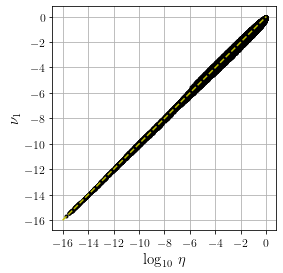

In [23]:
fig5 = plt.figure(figsize = (4, 4))
ax51 = fig5.add_subplot(111, aspect = "equal")
ax51.plot(
    eta_unscaler(output_data),
    eta_unscaler(output_prediction),
    "k."
)
ax51.plot([-16.0, 0.0], [-16.0, 0.0], "y--")
ax51.set_xticks(np.linspace(-16.0, 0.0, 9))
ax51.set_yticks(np.linspace(-16.0, 0.0, 9))
ax51.set_xlabel(r"$\log_{10}\,\eta$", fontsize = 15)
ax51.set_ylabel(r"$\nu_1$", fontsize = 15)
ax51.grid(True)
plt.tight_layout();

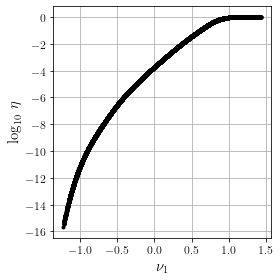

In [24]:
fig6 = plt.figure(figsize = (4, 4))
ax61 = fig6.add_subplot(111)
ax61.plot(
    center_prediction_arr[:,0],
    eta_unscaler(output_prediction),
    "k."
)
ax61.set_ylabel(r"$\log_{10}\,\eta$", fontsize = 15)
ax61.set_xlabel(r"$\nu_1$", fontsize = 15)
ax61.grid(True)
plt.tight_layout();

In [25]:
%matplotlib notebook

Effective = np.c_[ phi_unscaler(conformal_effective_outputs[:,0]), biot_unscaler(conformal_effective_outputs[:,1])]
Redundant = np.c_[phi_unscaler(conformal_redundant_outputs[:,0]),biot_unscaler(conformal_redundant_outputs[:,1])]

In [26]:
idx = (Effective[:,0]>-2)*(Effective[:,0]<6)
Effective = Effective[np.where(idx)]
idx = (Effective[:,1]>-4)*(Effective[:,1]<8)
Effective = Effective[np.where(idx)]

In [27]:
idx = (Redundant[:,0]>-2)*(Redundant[:,0]<6)
Redundant = Redundant[np.where(idx)]
idx = (Redundant[:,1]>-4)*(Redundant[:,1]<8)
Redundant = Redundant[np.where(idx)]

In [28]:
Effective_torch =  \
        torch.from_numpy(np.c_[phi_scaler.transform(Effective[:,0].reshape(-1,1)),
                               biot_scaler.transform(Effective[:,1].reshape(-1,1))])
Network_Effective_Center = encoder(Effective_torch)
effective_eta_network = eta_unscaler(predictor(Network_Effective_Center[:,0].reshape(-1,1)))

In [29]:
Redundant_torch =  \
        torch.from_numpy(np.c_[phi_scaler.transform(Redundant[:,0].reshape(-1,1)),
                               biot_scaler.transform(Redundant[:,1].reshape(-1,1))])
Network_Redundant_Center = encoder(Redundant_torch)
redundant_eta_network = eta_unscaler(predictor(Network_Redundant_Center[:,0].reshape(-1,1)))

<IPython.core.display.Javascript object>


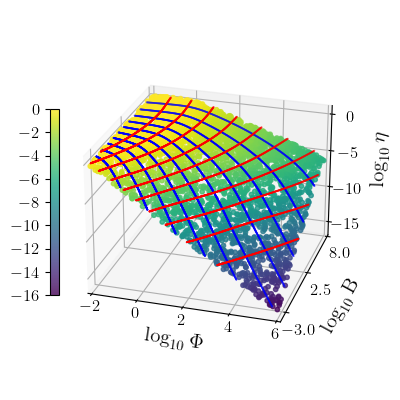

In [30]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(Effective[:,0],
    Effective[:,1],effective_eta_network*0.99,c='r',s=0.1,zorder=10)
ax.scatter(Redundant[:,0],
    Redundant[:,1],redundant_eta_network*0.99,c='b',s=0.1,zorder=10)

p = ax.scatter(np.log10(phi)[::3],np.log10(biot)[::3],
               np.log10(eta)[::3],c=np.log10(eta)[::3],
               s=10,alpha=0.8,zorder=-5,vmin=-16,vmax=0)
plt.colorbar(p,location='left',pad=-0.01,fraction=0.03,ticks=np.linspace(-16.0, 0.0, 9))
ax.set_xlim(-2,6)
ax.set_ylim(-4,8)
ax.view_init(25,-73)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = -5
ax.tick_params(axis='x', pad=-5)
ax.tick_params(axis='y', pad=0)
ax.tick_params(axis='z', pad=1)
ax.set_yticks([-3,2.5,8])
ax.set_xlabel('$\log_{10}\Phi$')
ax.set_ylabel('$\log_{10}\,$B')
ax.set_zlabel(r'$\log_{10}\eta$')
ax.grid(True)

# Save Model and Data

In [31]:
if not load_weights:
    model_dict = {
        "epoch": epoch,
        "encoder_state_dict": encoder.state_dict(),
        "encoding_optimizer_state_dict": encoding_optimizer.state_dict(),
        "encoding_scheduler": encoding_scheduler,
        "decoder_state_dict": decoder.state_dict(),
        "decoding_optimizer_state_dict": decoding_optimizer.state_dict(),
        "decoding_scheduler": decoding_scheduler,
        "predictor_state_dict": predictor.state_dict(),
        "prediction_optimizer_state_dict": prediction_optimizer.state_dict(),
        "prediction_scheduler": prediction_scheduler,
        "conformality_loss": conformality_loss,
        "prediction_loss": prediction_loss
    }

    if estimator is not None:
        model_dict["estimator_state_dict"] = estimator.state_dict()
        model_dict["estimation_state_dict"] = estimation_optimizer.state_dict()
        model_dict["estimation_scheduler"] = estimation_scheduler
    else:
        model_dict["estimator_state_dict"] = None
        model_dict["estimation_state_dict"] = None
        model_dict["estimation_scheduler"] = None

    torch.save(model_dict, "Effectiveness_Factor_CAE.pt")

In [32]:
df = pd.DataFrame(
    data = np.c_[phi, biot, eta],
    columns = ["thiele", "biot", "eta"]
)

df["effective"] = tensor2array(conformal_coordinates[:,0])
df["redundant"] = tensor2array(conformal_coordinates[:,1])
df["recon_phi"] = 10.0**phi_unscaler(input_reconstruction[:,0])
df["recon_biot"] = 10.0**biot_unscaler(input_reconstruction[:,1])

if not load_weights:
    df.to_excel("Effectiveness_Factor_Data.xlsx", index = False)

In [33]:
end_time = datetime.now()
print(end_time - start_time)

0:00:04.277483
